In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras


In [ ]:
from tensorflow import keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
import os, glob
import numpy as np # calculator library
import seaborn as sns # data visualization library based on matplotlib
import matplotlib.pyplot as plt # data visualization library
import pandas as pd # dataframe library

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [ ]:
file_path = '/content/drive/MyDrive/Research/RwithAlamin/sugarcane/sugarcane RA'

In [ ]:
name_class = os.listdir(file_path)
name_class

['Healthy', 'Bacterial Blight', 'Red Rot']

In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Filepath,Label
0,/content/drive/MyDrive/Research/RwithAlamin/su...,Healthy
1,/content/drive/MyDrive/Research/RwithAlamin/su...,Healthy
2,/content/drive/MyDrive/Research/RwithAlamin/su...,Red Rot
3,/content/drive/MyDrive/Research/RwithAlamin/su...,Red Rot
4,/content/drive/MyDrive/Research/RwithAlamin/su...,Bacterial Blight


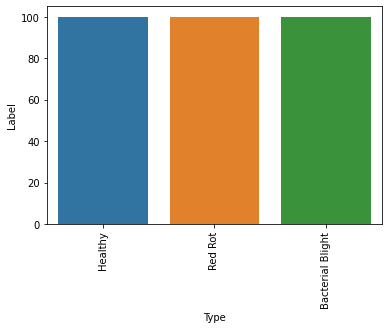

In [ ]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [ ]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

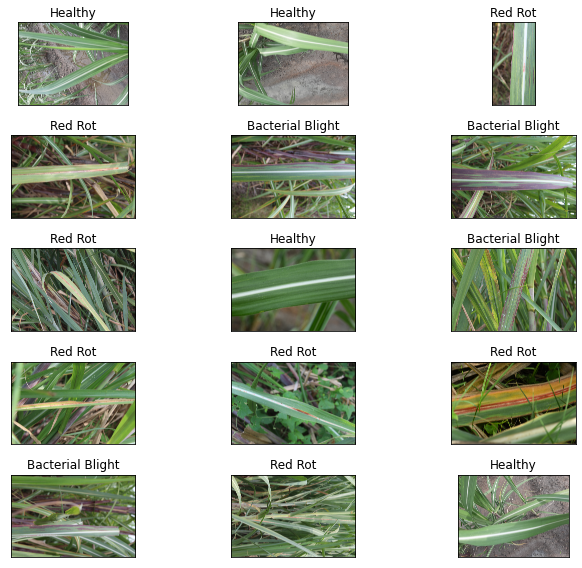

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 225 validated image filenames belonging to 3 classes.
Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.


In [ ]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=my_callbacks
)

Epoch 1/10
8/8 [==============================] - 242s 30s/step - loss: 1.1017 - accuracy: 0.4622 - val_loss: 0.6210 - val_accuracy: 0.7556
Epoch 2/10
8/8 [==============================] - 175s 23s/step - loss: 0.5068 - accuracy: 0.8178 - val_loss: 0.3754 - val_accuracy: 0.8533
Epoch 3/10
8/8 [==============================] - 172s 23s/step - loss: 0.3366 - accuracy: 0.8800 - val_loss: 0.2890 - val_accuracy: 0.8844
Epoch 4/10
8/8 [==============================] - 177s 24s/step - loss: 0.2347 - accuracy: 0.9022 - val_loss: 0.1939 - val_accuracy: 0.9556
Epoch 5/10
8/8 [==============================] - 173s 23s/step - loss: 0.1754 - accuracy: 0.9467 - val_loss: 0.1160 - val_accuracy: 0.9778
Epoch 6/10
8/8 [==============================] - 175s 23s/step - loss: 0.1064 - accuracy: 0.9867 - val_loss: 0.0792 - val_accuracy: 0.9822
Epoch 7/10
8/8 [==============================] - 176s 23s/step - loss: 0.0770 - accuracy: 0.9778 - val_loss: 0.0614 - val_accuracy: 0.9911
Epoch 8/10
8/8 [====

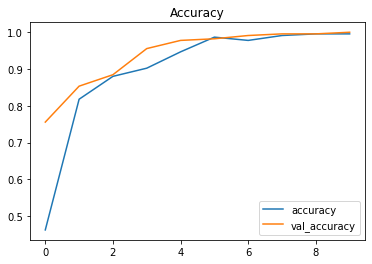

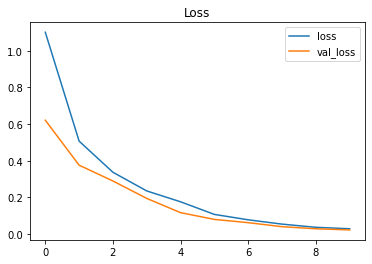

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.31326
Test Accuracy: 88.00%


In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

Bacterial Blight       0.81      0.93      0.87        28
         Healthy       0.96      1.00      0.98        24
         Red Rot       0.89      0.70      0.78        23

        accuracy                           0.88        75
       macro avg       0.89      0.87      0.88        75
    weighted avg       0.88      0.88      0.88        75



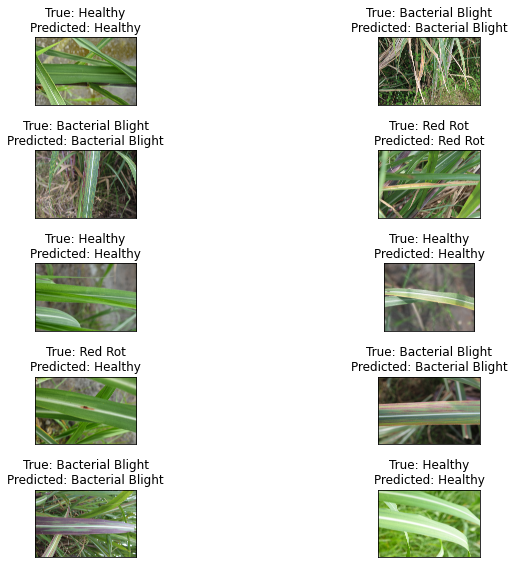

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()